In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [36]:
using BenchmarkTools;
using CUDA
using Base: @doc
using Revise
using Random: shuffle, randperm

push!(LOAD_PATH, "../../src");
using Pose2D
using Geometry: Segment
using MyUtils
using Raycaster
using SensorDistributions;

In [37]:
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt: @f_str, format # Python-style f-strings
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using GenDistributionZoo: ProductDistribution

const diagnormal = broadcasted_normal

mvuniform = ProductDistribution(uniform);

## Load Environment

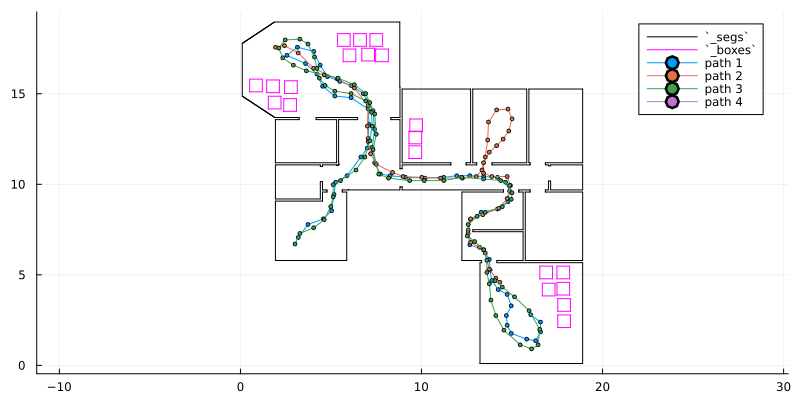

In [5]:
include("../../src/house_expo_utils.jl");

fname = "../data/task_inputs/test_env_2.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=2, c=col[i], label="path $i")
end
mypl

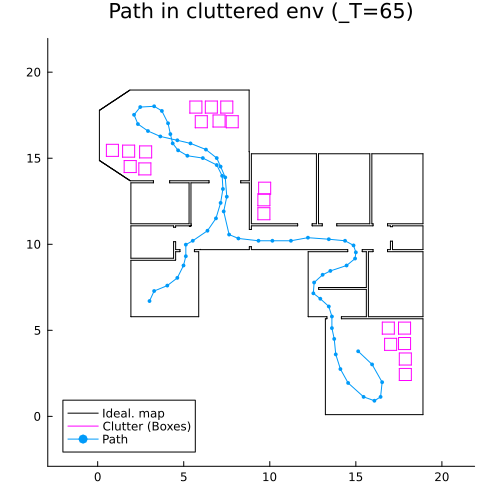

In [31]:
_ps, _us = unpack_path(_paths[3])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

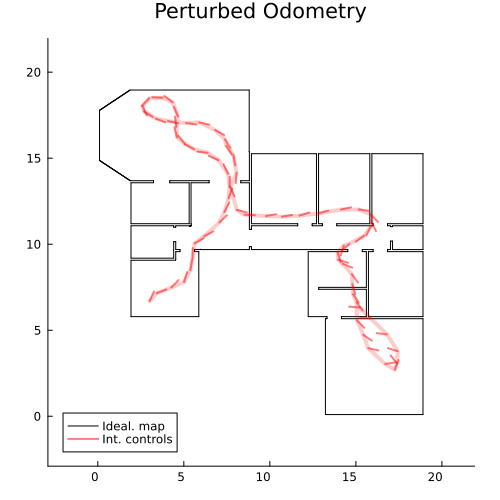

In [39]:
#nbx
x_noise  = 0.1
hd_noise = 5/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps_noisy = [_ps[1]]
for u in us_noisy
    push!(ps_noisy, ps_noisy[end] + u)
end

# -----------------
env_plt = plot(
    size=(500,500), aspect_ratio=:equal, title="Perturbed Odometry", axis=true, grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!([p.x for p in ps_noisy], c=:red, label=nothing, alpha=0.2, linewidth=4)

plot!(ps_noisy[[1]],     c=:red,  r=.6, label="Int. controls", alpha=0.5, linewidth=2)
plot!(ps_noisy[2:end], c=:red,  r=.6,  label=nothing,  alpha=0.5, linewidth=2)
env_plt

In [28]:
#nbx
"""
    zs, _as, ys = create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    
Return depth measurements `zs` and the angles `_as` along which the measuremnts were taken, 
and their 2D point cloud version `ys` for a given set of poses `ps` and a map `segs` of line
segments.

Example:
```julia
    _obs_noise = 0.1
    _fov       = 2π
    _num_a     = 361
    _zs, _as, _ys   = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)
```
"""
function create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    segs = stack(Vector.(segs));
    ps   = stack(Vector.(ps));

    zs  = cast(ps, segs; fov=fov, num_a=num_a)
    zs += _obs_noise * randn(size(zs))
    zs  = unstack(zs);

    as  = [range(-fov/2, fov/2, _num_a)...];
    ys  = [polar_inv(z,as) for z in zs]
    return zs, as, ys
end

create_observations

In [29]:
#nbx
_obs_noise = 0.1
_fov       = 2π
_num_a     = 100

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

# -------------
println("Created a few new variables:\n")
summarize_vars(:(_obs_noise, _fov, _as, _zs, _ys))
println("")

Created a few new variables:

_obs_noise Float64
_fov       Float64
_as        Vector{Float64}
_zs        Vector{Vector{Float64}}
_ys        Vector{Vector{Vector{Float64}}}



[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif")
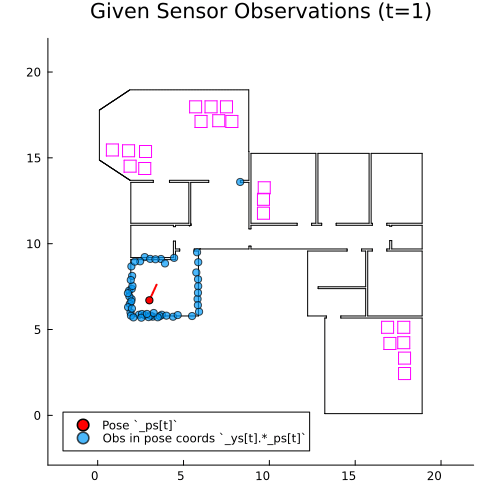

In [30]:
# -----------------------
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = _ys[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Given Sensor Observations (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:magenta, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(shuffle(y[1:2:end]).*p, c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")
    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=4)

In [263]:
include("../../src/grid_proposals.jl")

function eval_pose_vectors2(
    vs   :: Array{Vector{Float64}},
    z    :: Vector{Float64},
    segs :: Vector{Segment},
    fov, num_a, w::Int,
    sig, outlier,
    zmax::Float64=50.0; sorted=false)

    # Compute sensor measurements and
    # Gaussian mixture components
    # p_  = CuArray(Vector(p))
    # ps_ = reshape(p_, 1, 3)

    ps   = stack(vs[:])
    segs = stack(Vector.(segs))
    as   = create_angles(fov, num_a)

    # if _cuda[]
    # ps   = CuArray(ps)
    # z    = CuArray(z)
    # segs = CuArray(segs)
    # as   = CuArray(as)
    # end

    z = clamp.(z, 0.0, zmax)

    zs = cast(ps, segs; fov=fov, num_a=num_a, zmax=zmax)
    ỹ, d̃ = get_1d_mixture_components(zs, as, w);

    # Evaluate the the observations with respect to the
    # different Gaussian mixtures computed above
    log_ps,_,outl = depthdist_logpdf(z, ỹ, d̃, sig, outlier, zmax;
                        scale_noise=false, return_pointwise=false, return_outliermap=true);

    # Move everyting back to CPU if is not already there
    log_ps = Array(log_ps)

    # Sort by log prob
    # and return
    # if sorted
    # perm   = sortperm(log_ps)
    # log_ps = log_ps[perm]
    # vs     = vs[:][perm]
    # end

    return log_ps, outl
end;

(6, 6, 6)
  0.937366 seconds (242.25 k allocations: 530.947 MiB, 5.18% gc time, 10.36% compilation time)
(216, 10, 10)(216, 100, 10, 10)
CartesianIndex(166, 2, 1)
maximum log prob: 62.94525128198298


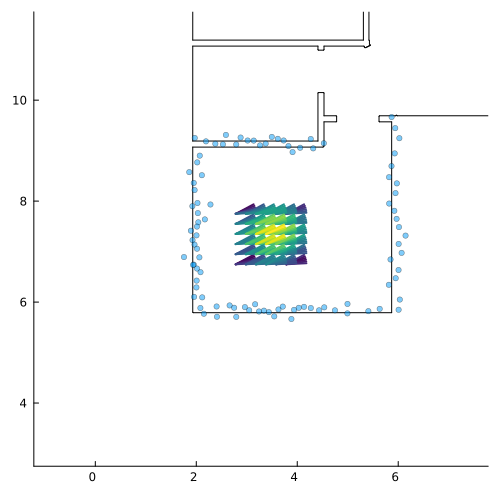

In [264]:
# t = 15
t = 2
z = _zs[t]
p0 = _ps[t] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))

v0 = Vector(p0)
grid_args = (
    k = [6, 6, 6],
    r = [.2, .2, 5/180*π],
)


vs, = vector_grid(v0, grid_args...)

println(size(vs))


w       = 10
sig     = range(0.05, 0.7, 10)
outlier = range(0.01, 0.7, 10)
zmax    = 25.

@time log_ps, outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

println(size(log_ps), size(outl))
i = argmax(log_ps)
println(i)
x = polar_inv(z, _as)

println("maximum log prob: ", maximum(log_ps))
vals = log_ps[:,i[2],i[3]]
perm = sortperm(vals)
vals = vals[perm]

# -----------------------------
delta = 4
mypl = plot(size=(500,500), legend=nothing, aspect_ratio=:equal,  grid=false, showaxis = true,
    xlim=(vs[1][1]-delta, vs[end][1]+delta),
    ylim=(vs[1][2]-delta, vs[end][2]+delta) 
)
plot!(_segs, c=:black)
cs = cgrad(:viridis)[peak_to_peak(vals)]
plot!(Pose.(vs[perm]), cs, r=.4, linewidth=2)
scatter!(x .* Pose(vs[i[1]]), markerstrokewidth=0.5, c=col[1], alpha=0.5, markersize=3)
display(mypl)


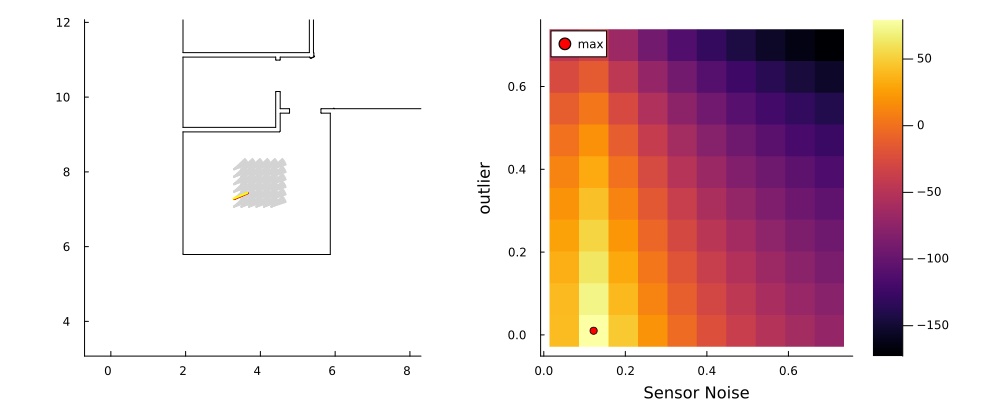

In [261]:
m = dropdims(maximum(log_ps, dims=1), dims=1)
I = dropdims(argmax(log_ps, dims=1), dims=1)
imax = argmax(log_ps)

# -----------------------------
plot_1 = plot(size=(600,400), title="",
    grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm
)
heatmap!(sig, outlier, m')
scatter!([sig[imax[2]]],outlier[[imax[3]]], label="max", c=:red)

# -----------------------------
plot_2 = plot(size=(500,500), legend=nothing, aspect_ratio=:equal,  grid=false, showaxis = true,
xlim=(vs[1][1]-delta, vs[end][1]+delta),
ylim=(vs[1][2]-delta, vs[end][2]+delta) 
)
plot!(_segs, c=:black)

plot!(Pose.(vs[:]), c=:lightgray, r=.4, linewidth=2)
for i in I
    plot!(Pose(vs[i[1]]), r=.4, c=:gray, linewidth=1)
end
plot!(Pose(vs[imax[1]]), r=.4, c=:red, linewidth=2)
plot!(_ps[t], r=.4, c=:yellow, linewidth=2)

# -----------------------------
plot(plot_2, plot_1, layout=(1,2), size=(1000,400), margin=3Plots.mm)


  1.250327 seconds (1.08 k allocations: 872.809 MiB, 4.89% gc time)
  1.261101 seconds (1.18 k allocations: 872.817 MiB, 3.04% gc time)
  1.305437 seconds (1.18 k allocations: 872.817 MiB, 5.96% gc time)
  1.285008 seconds (1.18 k allocations: 872.817 MiB, 5.44% gc time)
  1.266068 seconds (1.18 k allocations: 872.817 MiB, 5.54% gc time)
  1.253722 seconds (1.18 k allocations: 872.817 MiB, 5.60% gc time)
  1.250403 seconds (1.18 k allocations: 872.817 MiB, 5.59% gc time)
  1.247399 seconds (1.18 k allocations: 872.817 MiB, 5.61% gc time)
  1.274187 seconds (1.18 k allocations: 872.817 MiB, 6.23% gc time)
  1.277597 seconds (1.18 k allocations: 872.817 MiB, 5.48% gc time)
  1.283053 seconds (1.18 k allocations: 872.817 MiB, 5.50% gc time)
  1.245585 seconds (1.18 k allocations: 872.817 MiB, 5.66% gc time)
  1.285372 seconds (1.18 k allocations: 872.817 MiB, 5.43% gc time)
  1.232936 seconds (1.18 k allocations: 872.817 MiB, 5.62% gc time)
  1.266679 seconds (1.18 k allocations: 872.817 

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/hierarchical_sensor.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/hierarchical_sensor.gif")
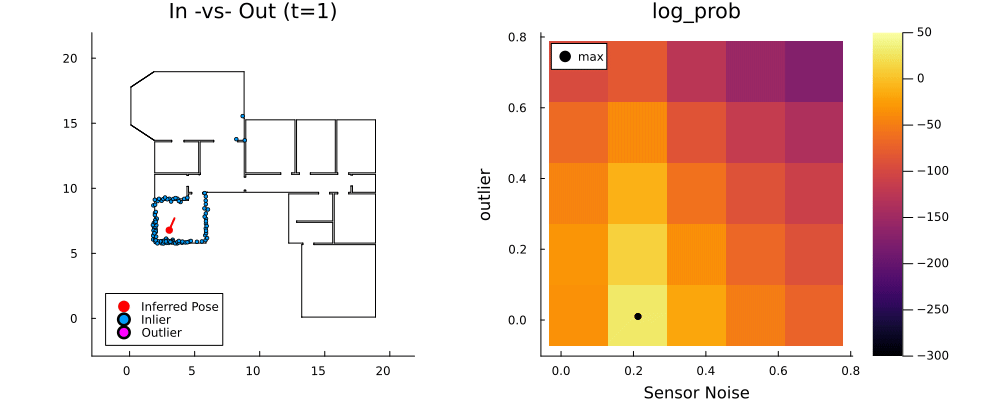

In [276]:

q = _ps[1] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))
qs = []
ani = Animation()
for t=1:_T

    z = _zs[t]
    y = _ys[t]

    v0 = Vector(q)
    grid_args = (
        k = [9, 9, 9],
        r = [.2, .2, 5/180*π],
    )

    vs, = vector_grid(v0, grid_args...)


    w       = 10
    sig     = range(0.05, 0.7, 5)
    outlier = range(0.01, 0.7, 5)
    zmax    = 25.

    @time log_ps,outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

    q = Pose(vs[argmax(log_ps)[1]])
    push!(qs, q)
    
    m = dropdims(maximum(log_ps, dims=1), dims=1)
    I = dropdims(argmax(log_ps, dims=1), dims=1)
    imax = argmax(log_ps)

    # -----------------------------
    agent_plot = plot(
        size=(500,500), aspect_ratio=:equal, title="In -vs- Out (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    # plot!(_boxes, c=:magenta, label=nothing)
    plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    scatter!(shuffle(y[.!outl[imax[1],:,imax[2],imax[3]]]).*q, c=col[1], markersize=2, alpha=1., markerstrokewidth=1, label="Inlier")
    scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=1., markerstrokewidth=1, label="Outlier")
    # -----------------------------
    heat_plot = plot(size=(600,400), title="log_prob",
        grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm
    )
    heatmap!(sig, outlier, m', clim=(-300,50))
    scatter!([sig[imax[2]]],outlier[[imax[3]]], label="max", c=:black)
    # -----------------------------
    frame(ani, plot(agent_plot, heat_plot, layout=(1,2), size=(1000,400), margin=3Plots.mm))


    q = q + _us[t] + Control(diagnormal([0.;0.],[0.1;0.1]), normal(0, 5/180*π))
end
gif(ani, "_imgs/hierarchical_sensor.gif", fps=5)
# gif(ani, fps=5)

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif")
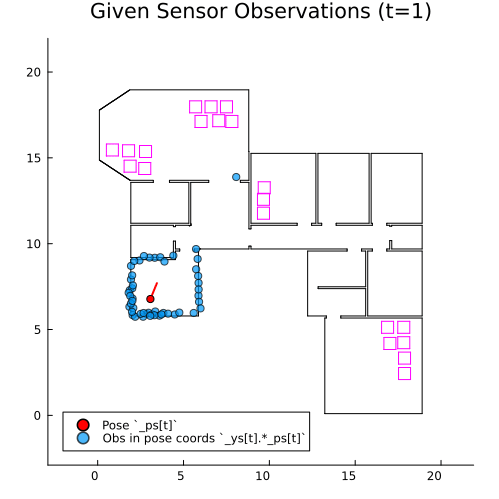

In [242]:
# -----------------------
ani = Animation()
for t=1:1:length(qs)
    p = qs[t]
    y = _ys[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Given Sensor Observations (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:magenta, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(shuffle(y[1:2:end]).*p, c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")
    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=5)

(1, 360, 100, 100)
min = -941.1456284718366 max = -344.53750305253425
min = -2486.7918085188167 max = -827.0558927431349


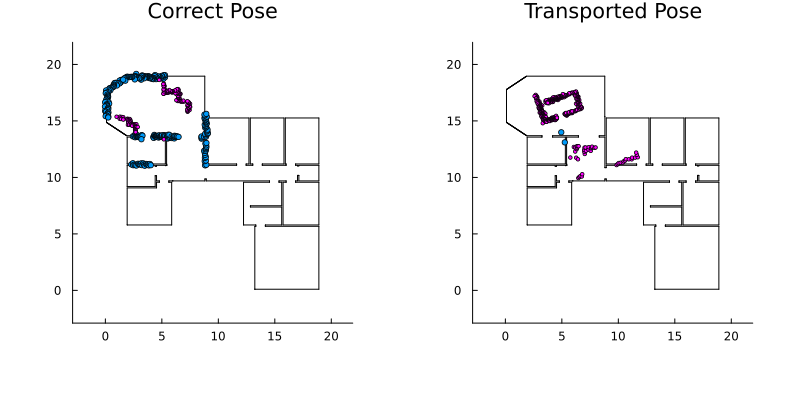

In [139]:
t1 = 4
t2 = 25

w       = 20
sig     = range(0.05, 2., 100)
outlier = range(0.01,1., 100)
zmax    = 10.


p = _ps[t1] + Control(diagnormal([0.0;0.0], [0.1;0.1]), normal(0, 0.01/180*π))

vs   = stack(Vector.([p]));
segs = stack(Vector.(_segs));

vs_ = DeviceArray(vs)
segs_ = DeviceArray(segs)

zs   = cast(vs_, segs_; fov=_fov, num_a=_num_a, zmax=zmax)
zs_ = DeviceArray(zs)
as_ = DeviceArray(_as);

ỹ, d̃ = get_1d_mixture_components(zs_, as_, w);

ỹ_ = DeviceArray(ỹ)
d̃_ = DeviceArray(d̃)
sig_     = DeviceArray(sig)
outlier_ = DeviceArray(outlier)

zs1_ = DeviceArray(_zs[t1])
zs2_ = DeviceArray(_zs[t2])

log_p1, ptw1, outl1 = depthdist_logpdf(zs1_, ỹ_, d̃_, sig_, outlier_, zmax; 
                                    return_pointwise=true, return_outliermap=true);

log_p2, ptw2, outl2 = depthdist_logpdf(zs2_, ỹ_, d̃_, sig_, outlier_, zmax; 
                                    return_pointwise=true, return_outliermap=true);

log_p1 = Array(log_p1)
log_p2 = Array(log_p2);

println(size(outl1))

println("min = $(minimum(log_p1)) max = $(maximum(log_p1))")
println("min = $(minimum(log_p2)) max = $(maximum(log_p2))")

i1 = argmax(log_p1[1,:,:])
i2 = argmax(log_p2[1,:,:])


# -----------------------
plot_1 = plot(size=(500,500), aspect_ratio=:equal, title="Correct Pose", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
scatter!(_ys[t1][.!outl1[1,:,i1]] .* p, c=col[1], linewidth=1, markersize=3, label="Path")
scatter!(_ys[t1][  outl1[1,:, i1]] .* p, c=:magenta, linewidth=1, markersize=2, label="Path")

plot_2 = plot(size=(500,500), aspect_ratio=:equal, title="Transported Pose", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
scatter!(_ys[t2][.!outl2[1,:,i2]] .* p, c=col[1], linewidth=1, markersize=3, label="Path")
scatter!(_ys[t2][  outl2[1,:,i2]] .* p, c=:magenta, linewidth=1, markersize=2, label="Path")

plot(plot_1, plot_2, layout=(1,2),  size=(800,400), legend=false,
    right_margin  = 10Plots.mm,
    left_margin   = 10Plots.mm,
    bottom_margin = 10Plots.mm
)

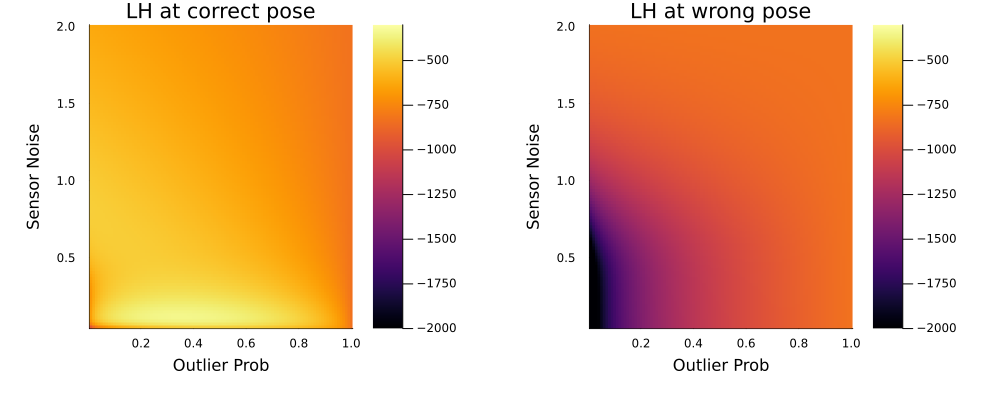

In [142]:
plot_1 = plot(size=(400,400), title = "LH at correct pose",
    grid=false, xlabel="Outlier Prob", ylabel="Sensor Noise", right_margin = 10Plots.mm
)
heatmap!(sig, log_p1[1,:,:], clim=(-2000, -300))

plot_2 = plot(size=(400,400), title = "LH at wrong pose",
    grid=false, xlabel="Outlier Prob", ylabel="Sensor Noise", right_margin = 10Plots.mm
)
heatmap!(outlier, sig, log_p2[1,:,:], clim=(-2000, -300))

plot(plot_1, plot_2, layout=(1,2),  size=(1000,400), legend=false,
    right_margin  = 10Plots.mm,
    left_margin   = 10Plots.mm,
    bottom_margin = 10Plots.mm
)

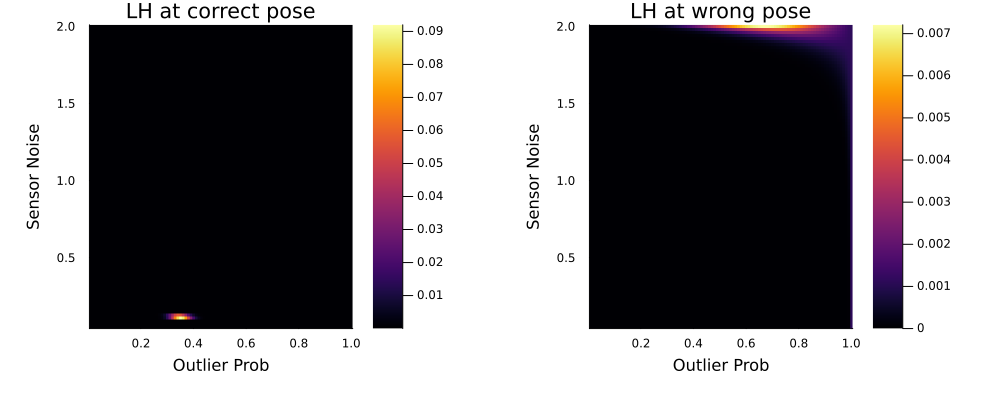

In [143]:
prob1 = exp.(log_p1[1,:,:] .- logsumexp(log_p1[1,:,:]))
prob2 = exp.(log_p2[1,:,:] .- logsumexp(log_p2[1,:,:]))


plot_1 = plot(size=(400,400), title = "LH at correct pose",
    grid=false, xlabel="Outlier Prob", ylabel="Sensor Noise", right_margin = 10Plots.mm
)
heatmap!(outlier, sig, prob1)

plot_2 = plot(size=(400,400), title = "LH at wrong pose",
    grid=false, xlabel="Outlier Prob", ylabel="Sensor Noise", right_margin = 10Plots.mm
)
heatmap!(outlier, sig, prob2)

plot(plot_1, plot_2, layout=(1,2),  size=(1000,400), legend=false,
    right_margin  = 10Plots.mm,
    left_margin   = 10Plots.mm,
    bottom_margin = 10Plots.mm
)